# Compute Insolation for hadgem forcing file locations

In [2]:
println("Hello, world!")

Hello, world!


In [ ]:
using Pkg; Pkg.activate("../")

using Dates
using Statistics

using Insolation
import Insolation.Parameters as IP 
import ClimaParams as CP

using NCDatasets

FT = Float64

In [45]:
# for site 23
lat = 17.
lon = 211.
timezone = -10.

date = DateTime(2008, 07, 01)

ntimes = 10000
hours = collect(range(0, 24 * 31, length = ntimes))
insol = zeros(ntimes) 
sza = zeros(ntimes)
date0 = DateTime("2000-01-01T11:58:56.816")

param_set = IP.InsolationParameters(FT)
od = Insolation.OrbitalData()

for (i, hr) in enumerate(hours)
    h = Int(round(hr + timezone))
    m = Int(round((hr + timezone - h) * 60))

    datetime = date + Dates.Hour(h) + Dates.Minute(m)
    S, mu = solar_flux_and_cos_sza(datetime, date0, od, lon, lat, param_set)
    insol[i] = S * mu 
    sza[i] = rad2deg(acos(mu))
end


In [46]:
using CairoMakie
sum(insol .* cos.(sza)) / sum(insol)

0.013829336461593716

In [78]:
v = cos.(deg2rad.(sza)) .* insol/ sum(insol)
sum(v)

0.7807716170596987

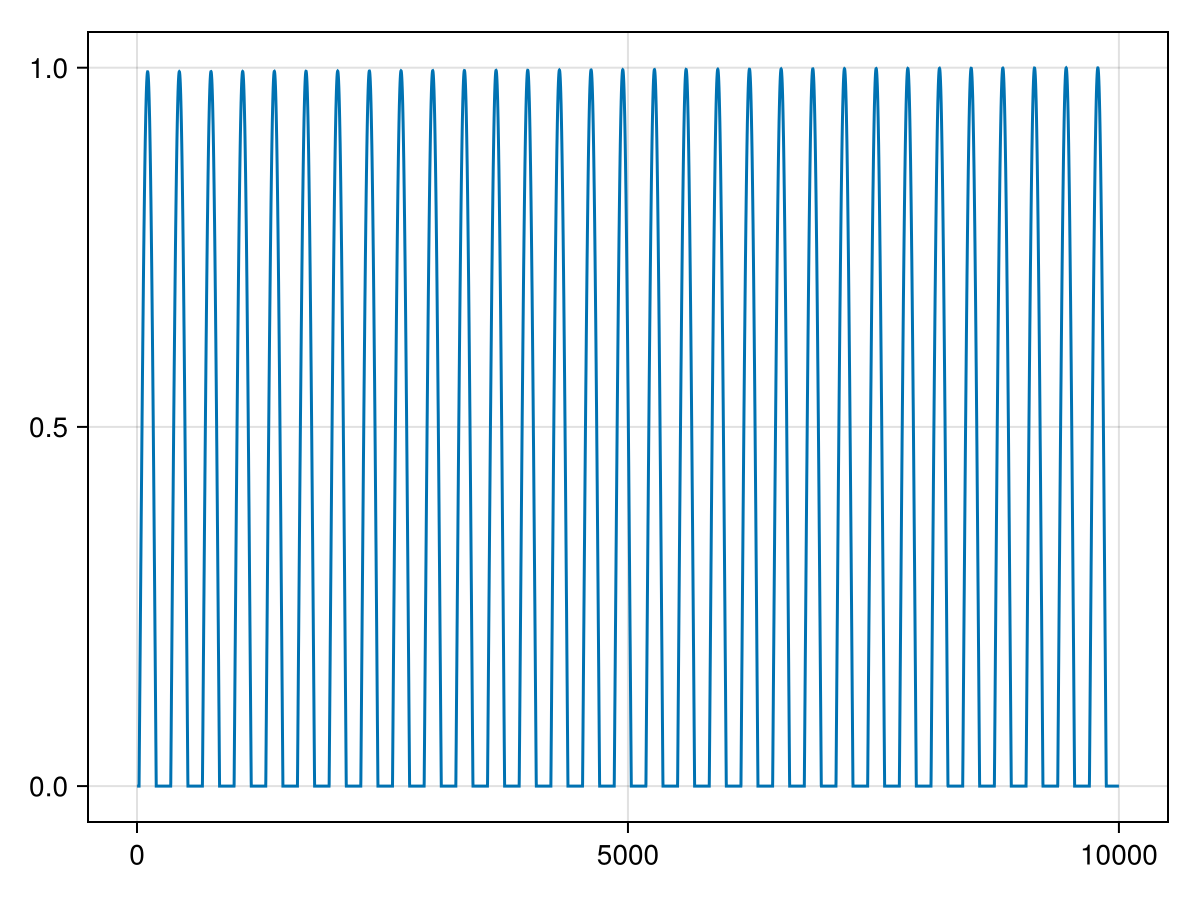

In [73]:
lines(cos.(deg2rad.(sza)))

In [93]:
geo = NCDataset("geolocation.nc")
geo["site"][:]
geo["lon"][:]

273.5f0

In [108]:
function get_weighted_coszen(lat, lon, month, timezone=-10., year = 2008, ndays = 31;
    param_set = IP.InsolationParameters(FT),
    od = Insolation.OrbitalData())

    date = DateTime(year, month, 01)

    ntimes = ndays * 24 * 60 # sample every minute
    hours = collect(range(0, 24 * ndays, length = ntimes))
    insol = zeros(ntimes) 
    sza = zeros(ntimes)
    date0 = DateTime("2000-01-01T11:58:56.816")

    for (i, hr) in enumerate(hours)
        h = Int(round(hr + timezone))
        m = Int(round((hr + timezone - h) * 60))

        datetime = date + Dates.Hour(h) + Dates.Minute(m)
        S, mu = solar_flux_and_cos_sza(datetime, date0, od, FT(lon), FT(lat), param_set)
        insol[i] = S * mu 
        sza[i] = rad2deg(acos(mu))
    end

    v = cos.(deg2rad.(sza)) .* insol/ sum(insol)

    return sum(v)
end
# test function 
get_weighted_coszen(85., 211., 6)

0.3988335214156181

In [115]:
jan = get_weighted_coszen.(geo["lat"][:], geo["lon"][:], 1)
april = get_weighted_coszen.(geo["lat"][:], geo["lon"][:], 4)
july = get_weighted_coszen.(geo["lat"][:], geo["lon"][:], 7)
oct = get_weighted_coszen.(geo["lat"][:], geo["lon"][:], 10)

119-element Vector{Float64}:
 0.7681883871097257
 0.7681611193950699
 0.7681353718685542
 0.7681113738814465
 0.7680893585038041
 0.7680695619426244
 0.7680522224111387
 0.7718075889560638
 0.7750522794823018
 0.7777830342949876
 ⋮
 0.7148836512859689
 0.7001978649347049
 0.684263511878199
 0.666990127601133
 0.7179527760820467
 0.10703147026393467
 0.1520560437432114
 6.123233995736766e-17
 0.31805109107316293

In [132]:
length(geo["site"][:])
coszen_data = zeros(Float64, 4, length(geo["site"][:]), 4)

ds

Dataset: coszen_data.nc
Group: /

Dimensions
   site = 1
   time = 4

Variables
  lat   (1)
    Datatype:    Float64 (Float64)
    Dimensions:  site

  lon   (1)
    Datatype:    Float64 (Float64)
    Dimensions:  site

  time   (4)
    Datatype:    Int64 (Int64)
    Dimensions:  time

  coszen   (1 × 4)
    Datatype:    Float64 (Float64)
    Dimensions:  site × time



In [153]:
# make a NCdataset indexed by geo site lat and lon with cozsen data for each of the 4 selected months
using NCDatasets

# Create a new NetCDF file
ds = NCDataset("coszen_data.nc", "c")

# Define dimensions
site_dim = defDim(ds, "site", length(geo["site"][:]))
time_dim = defDim(ds, "date", 4)

# Define variables
site_var = defVar(ds, "site", Int, ("site",))
lat_var = defVar(ds, "lat", Float64, ("site",))
lon_var = defVar(ds, "lon", Float64, ("site",))
time_var = defVar(ds, "date", Int, ("date",))
coszen_var = defVar(ds, "coszen", Float64, ("site", "date"))

# Assign data to variables
site_var[:] = geo["site"][:]
lat_var[:] = geo["lat"][:]
lon_var[:] = geo["lon"][:]
time_var[:] = [20080101, 20080401, 20080701, 20081001]  # Corresponding to January, April, July, October 2008

# Create a 3D array to hold coszen data
coszen_data = zeros(Float64, length(geo["site"][:]), 4)
coszen_data[:, 1] = jan
coszen_data[:, 2] = april
coszen_data[:, 3] = july
coszen_data[:, 4] = oct

coszen_var[:, :] = coszen_data

# Close the dataset
close(ds)

closed Dataset

In [ ]:
1

In [146]:
ds = NCDataset("coszen_data.nc", "r")
ds["coszen"][:, 2]

119-element Vector{Float64}:
 0.6814672688681445
 0.6814822410929781
 0.6814931428142965
 0.6815000418429809
 0.6815030283070099
 0.6815022132760595
 0.6814977272535974
 0.691315886917481
 0.7006566014905536
 0.7095181129572607
 ⋮
 0.7799626834990147
 0.7759318315591766
 0.7704336648680987
 0.76349084636207
 0.7805875636167589
 0.31736152808588813
 0.37349859333162855
 0.19497124193762871
 0.10176618534489221